In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from zipfile import ZipFile
import pandas as pd
import torch
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

from HP import PointProcessStorage, DirichletMixtureModel, EM_clustering
from metrics import consistency, purity
from data_utils import load_data

In [3]:
path = Path('../..', 'data', 'IPTV_Data')
ss, Ts, class2idx = load_data(path, nfiles=300, type='txt', datetime=True, maxlen=100)

In [12]:
N = len(ss)

In [13]:
D = 1
basis_fs = [lambda x: torch.exp(- x**2 / (10.*(k+1)) ) for k in range(D)]

In [14]:
hp = PointProcessStorage(ss, Ts, basis_fs)

In [15]:
C = len(class2idx)
K = 10

In [16]:
Sigma = torch.rand(C, C).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, D, K) * 10.
B = 1. + torch.rand(C, K) * 10.
alpha = 1.

model = DirichletMixtureModel(K, C, D, alpha, B, Sigma)
EM = EM_clustering(hp, model, n_inner=4)


In [17]:
pi = torch.FloatTensor([1./ K for _ in range(K)])

In [18]:
print(f'Initial NLL / N: {EM.hp_nll(pi, model.mu, model.A).item() / len(ss)}')

Initial NLL / N: 48312.357859531774


In [19]:
ntrials = 10
niter = 5

labels = torch.zeros(ntrials, len(ss))
nlls = torch.zeros(ntrials, niter)

for i in trange(ntrials):
    Sigma = (torch.eye(C, C) + torch.rand(C, C)).unsqueeze(-1).unsqueeze(-1).repeat(1,1, D, K) * 10
    B = 1 + torch.rand(C, K) * 10
    alpha = 1.

    model = DirichletMixtureModel(K, C, D, alpha, B, Sigma)
    EM.model = model
    r, nll_history = EM.learn_hp(niter=niter)
    
    labels[i] = r.argmax(-1)
    nlls[i] = torch.FloatTensor(nll_history)

  0%|          | 0/10 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [12]:
assert (model.A >= 0).all()
assert (model.mu > 0).all()

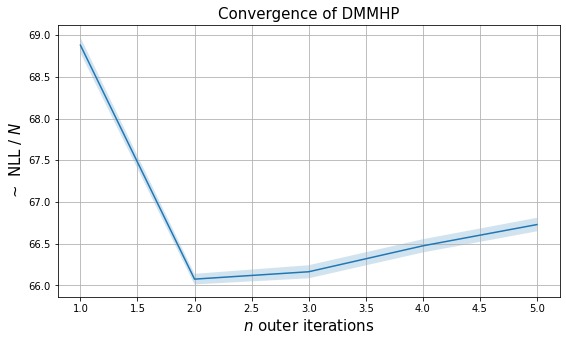

In [13]:
plt.figure(figsize=(9, 5))
plt.grid()
plt.plot(np.arange(niter)+1, nlls.mean(0).numpy() / len(ss))
plt.fill_between(np.arange(niter)+1, (nlls.mean(0).numpy() - nlls.std(0).numpy()) / len(ss), (nlls.mean(0).numpy() + nlls.std(0).numpy()) / len(ss), alpha=0.2)
plt.title('Convergence of DMMHP', fontsize=15)
plt.xlabel(r'$n$ outer iterations', fontsize=15)
plt.ylabel(r'$\sim$ NLL / $N$', fontsize=15)
plt.show()

In [14]:
print(f'Consistency of clustering: {consistency(labels).item():.4f}')

Consistency of clustering: 0.5758


In [4]:
path = Path('../..', 'data', 'simulated_Hawkes', 'K10_C10')
ss, Ts, class2idx = load_data(path, nfiles=1000, maxlen=1000, endtime=100, type='csv')

In [6]:
gt_ids = pd.read_csv(Path('../..', 'data', 'simulated_Hawkes', 'K10_C10', 'clusters.csv'))['cluster_id'].to_numpy()

In [7]:
gt_ids = torch.LongTensor(gt_ids)

In [9]:
N = len(ss)
D = 3
basis_fs = [lambda x: torch.exp(- x**2 / (2.*(k+1)**2) ) for k in range(D)]

hp = PointProcessStorage(ss, Ts, basis_fs)

C = len(class2idx)
K = 10

Sigma = torch.rand(C, C).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, D, K) * 10.
B = 1. + torch.rand(C, K) * 10.
alpha = 1.

model = DirichletMixtureModel(K, C, D, alpha, B, Sigma)
EM = EM_clustering(hp, model, n_inner=4)

pi = torch.FloatTensor([1./ K for _ in range(K)])

In [10]:
print(f'Initial NLL / N: {EM.hp_nll(pi, model.mu, model.A).item() / len(ss)}')

Initial NLL / N: 921278.1421421422


In [11]:
ntrials = 1
niter = 5

labels = torch.zeros(ntrials, len(ss))
nlls = torch.zeros(ntrials, niter)

for i in trange(ntrials):
    Sigma = (torch.eye(C, C) + torch.rand(C, C)).unsqueeze(-1).unsqueeze(-1).repeat(1,1, D, K) * 10
    B = 1 + torch.rand(C, K) * 10
    alpha = 1.

    model = DirichletMixtureModel(K, C, D, alpha, B, Sigma)
    EM.model = model
    r, nll_history = EM.learn_hp(niter=niter)
    
    labels[i] = r.argmax(-1)
    nlls[i] = torch.FloatTensor(nll_history)

100%|██████████| 1/1 [07:50<00:00, 470.97s/it]


In [12]:
assert (model.A >= 0).all()
assert (model.mu > 0).all()

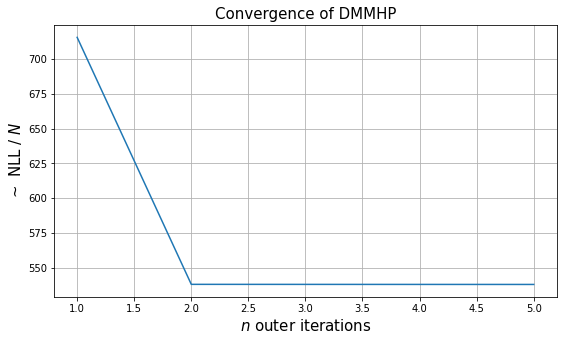

In [13]:
plt.figure(figsize=(9, 5))
plt.grid()
plt.plot(np.arange(niter)+1, nlls.mean(0).numpy() / len(ss))
plt.fill_between(np.arange(niter)+1, (nlls.mean(0).numpy() - nlls.std(0).numpy()) / len(ss), (nlls.mean(0).numpy() + nlls.std(0).numpy()) / len(ss), alpha=0.2)
plt.title('Convergence of DMMHP', fontsize=15)
plt.xlabel(r'$n$ outer iterations', fontsize=15)
plt.ylabel(r'$\sim$ NLL / $N$', fontsize=15)
plt.show()

In [18]:
pur_val = purity(r.argmax(1), gt_ids)

In [19]:
print(f'Purity: {pur_val}')

Purity: 0.13113113113113112
